In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import geopandas as gpd
import pandas as pd
import glob
import zipfile
import rasterio
import os
import xarray as xr
import json

Populating the interactive namespace from numpy and matplotlib


In [2]:
print(os.getcwd())
from pathlib import Path
folder = Path(r'../Data') # assumes working directory is onhm-fetcher-parser
print(folder)
# shapefiles = folder.glob("*_0[1-2].shp")
shapefiles = folder.glob("*.shp")
gdf = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)
gdf.reset_index(drop=True, inplace=True)
# gdf.plot()
print(gdf)

B:\GitRepos\onhm-fetcher-parser\notebooks
..\Data
       LAYER    POI_ID                                           geometry  \
0        NaN   7733855  POLYGON ((-73.37147648799998 41.11232830300003...   
1        NaN   7733919  POLYGON ((-73.38531621599998 41.13467480400004...   
2        NaN   7732571  POLYGON ((-73.41946539799994 41.16068341300007...   
3        NaN   7732387  POLYGON ((-73.41096625099993 41.15832593000005...   
4        NaN   7733327  (POLYGON ((-73.28636293699998 41.1278083500000...   
...      ...       ...                                                ...   
109946   NaN   4439814  POLYGON ((-123.682760808 41.59421288900006, -1...   
109947   NaN   2551733  (POLYGON ((-121.3264525819999 42.3195167990000...   
109948   NaN   2551733  POLYGON ((-121.149442958 42.23413625600006, -1...   
109949   NaN  24081601  POLYGON ((-121.441435272 42.80623224900006, -1...   
109950   NaN  24081601  (POLYGON ((-121.351904323 42.77765434300005, -...   

        hru_id_nat  hru_i

C:\Users\rmcd\anaconda3\envs\ofp_env\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [9]:
gdf['geometry'].bounds


,minx,miny,maxx,maxy
0,-73.412813,41.082234,-73.365144,41.135079
1,-73.430142,41.095923,-73.385141,41.157159
2,-73.427308,41.133839,-73.415918,41.160735
3,-73.419809,41.155644,-73.410608,41.160683
4,-73.313234,41.121045,-73.285928,41.140473
...,...,...,...,...
109946,-123.731146,41.543684,-123.681548,41.595731
109947,-121.326903,42.206705,-121.105124,42.392172
109948,-121.176962,42.192537,-121.142615,42.239481
109949,-121.595236,42.627172,-121.335524,42.806291


The code below is not optimum because it's base on the centroid of the hrus.  Therefore these values are better -126 54 -65 23

In [11]:
type(gdf['geometry'].bounds['minx'])
west = gdf['geometry'].bounds['minx'].min()
east = gdf['geometry'].bounds['maxx'].max()
south = gdf['geometry'].bounds['miny'].min()
north = gdf['geometry'].bounds['maxy'].max()
print(west, north, east, south)

-124.72462483099997 52.880049298000074 -66.94953853699997 24.839424370000074


https://thredds.daac.ornl.gov/thredds/ncss/ornldaac/1328/2018/daymet_v3_tmax_2018_na.nc4?var=lat&var=lon&var=tmax&north=54&west=-126&east=-65&south=23&horizStride=1&time_start=2018-01-01T12%3A00%3A00Z&time_end=2018-12-31T12%3A00%3A00Z&timeStride=1&accept=netcdf

https://thredds.daac.ornl.gov/thredds/ncss/ornldaac/1328/2018/daymet_v3_tmax_2018_na.nc4?var=lat&var=lon&var=tmax&north=54&west=-126&east=-65&south=23&disableProjSubset=on&horizStride=1&time_start=2018-01-01T12%3A00%3A00Z&time_end=2018-01-31T12%3A00%3A00Z&timeStride=1&accept=netcdf
 


In [15]:
import requests
from requests.exceptions import HTTPError
from datetime import datetime, timedelta
from urllib.parse import urlencode

prcpurl = 'https://thredds.daac.ornl.gov/thredds/ncss/ornldaac/1328/2018/daymet_v3_tmax_2018_na.nc4'
prcppayload = {
    'var': 'lat&var=lon&var=tmax',
    'north': '54',
    'west': '-126',
    'east': '-65',
    'south': '23',
    'disableProjSubset': 'on',
    'horizStride': '1',
    'time_start': '2018-12-31T00:00:00Z',
    'time_end': '2018-12-31T00:00:00Z',
    'timeStride': '1',
    'accept': 'netcdf'}    
try:
    s = requests.Session()
    #https://github.com/psf/requests/issues/1454
    qry = urlencode(prcppayload).replace('%26','&')
    qry = qry.replace('%3D', '=')
    print(qry)
    tmaxfile = requests.get(prcpurl, params=qry)
    tmaxfile.raise_for_status()
except HTTPError as http_err:
    print(f'HTTP error occured: {http_err}')
except Exception as err:
    print(f'Other error occured: {err}')
else:
    print('Gridmet data retrieved!')

var=lat&var=lon&var=tmax&north=54&west=-126&east=-65&south=23&disableProjSubset=on&horizStride=1&time_start=2018-12-31T00%3A00%3A00Z&time_end=2018-12-31T00%3A00%3A00Z&timeStride=1&accept=netcdf
Gridmet data retrieved!


In [16]:
with open('tmax_test2.nc', 'wb') as fh:
    fh.write(tmaxfile.content)
fh.close

<function BufferedWriter.close>

In [33]:
#=========================================================
#            MACAV2METDATA FILE PARAMETERS
#=========================================================
# dirPath='https://thredds.daac.ornl.gov/thredds/ncss/ornldaac/1328/2018/daymet_v3_prcp_2018_na.nc4?var=lat&var=lon&var=prcp&north=52.880049298000074+&west=-124.72462483099997+&east=-66.94953853699997+&south=24.839424370000074&disableLLSubset=on&disableProjSubset=on&horizStride=1&time_start=2018-12-31T00:00:00Z&time_end=2018-12-31T00:00:00Z&timeStride=1&accept=netcdf'
# fileName='/thredds/dodsC/MET/tmmx/tmmx_2019.nc'
dirPath = 'tmax_test2.nc'
# dirPath = 'daymet_v3_tmax_2018_na.nc4.nc'
#--------------------------------------------------------
#   FORM FILENAME AND GET HANDLE TO FILE AND DATA
#--------------------------------------------------------
fullfilename= dirPath
print(fullfilename)

ds = xr.open_dataset(fullfilename)

print(ds)

# df = ds.to_dataframe()

print('\n The meta data is: \n', ds.attrs)
lathandle=ds['lat']
lonhandle=ds['lon']
timehandle=ds['time']
datahandle=ds['tmax']
dhlat = ds['lat']
dhlon = ds['lon']
crshandle=ds['lambert_conformal_conic']
print('\n The crs meta data is \n', crshandle.attrs)
print(datahandle)
# crstransform = crshandle.attrs['GeoTransform']
# print(crstransform)

#collect data to describe geotransform
lonmin = float(ds.attrs['geospatial_lon_min'])
latmax = float(ds.attrs['geospatial_lat_max'])
# lonres = float(ds.attrs['geospatial_lon_resolution'])
# latres = float(ds.attrs['geospatial_lon_resolution'])

#Print some information on the data

print('\n Data attributes, sizes, and coords \n') 
print('\n Data attributes are: \n',datahandle.attrs)
print('\n Data sizes are: \n', datahandle.sizes)
print('\n Data coords are: \n', datahandle.coords)
print('\n Lat coords are: \n', dhlat.attrs)

ts = datahandle.sizes
print(type(ts))
print(ts['time'])
dayshape = ts['time']
Lonshape = ts['x']
Latshape = ts['y']
#dayshape,lonshape,latshape = datahandle.values.shape
print(dayshape, Lonshape, Latshape)

# datahandle.values[dayshape-1,:,:].shape

# print(lathandle.values.shape)
# print(type(lathandle.values))
# print(datahandle.dtype)
# print(np.isfortran(datahandle.values))

tmax_test2.nc
<xarray.Dataset>
Dimensions:                  (time: 1, x: 5904, y: 3377)
Coordinates:
  * y                        (y) float32 1687.0 1686.0 ... -1688.0 -1689.0
  * x                        (x) float32 -2650.25 -2649.25 ... 3251.75 3252.75
  * time                     (time) datetime64[ns] 2018-12-30T12:00:00
Data variables:
    lat                      (y, x) float32 ...
    lambert_conformal_conic  int16 ...
    lon                      (y, x) float32 ...
    tmax                     (time, y, x) float32 ...
Attributes:
    _NCProperties:       version=1|netcdflibversion=4.6.1|hdf5libversion=1.10.2
    start_year:          2018
    source:              Daymet Software Version 3.0
    Version_software:    Daymet Software Version 3.0
    Version_data:        Daymet Data Version 3.0
    Conventions:         CF-1.6
    citation:            Please see http://daymet.ornl.gov/ for current Dayme...
    references:          Please see http://daymet.ornl.gov/ for current infor..

ValueError: x and y must be coordinate variables

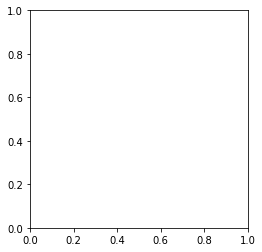

In [37]:
f1, ax1 = plt.subplots(1)
ax1.set_aspect('equal')
# ax1.set(xlim=(-130, -60), ylim=(20, 55))
ptmax = ds.tmax
ptmax_1 = ptmax.isel(time=0)
ptmax_1.plot(ax=ax1, x='lon', y='lat', cmap='viridis')
f1.tight_layout()
f1.savefig('gridmet.png')

In [35]:
np.nanmean(ptmax_1.values)


-1.2361121

In [53]:
earth_radius = 6371008.7714
degrees_to_radians = math.pi/180.0
radians_to_degrees = 180.0/math.pi

def change_in_latitude(m):
    "Given a distance north, return the change in latitude."
    return (m/earth_radius)*radians_to_degrees

def change_in_longitude(latitude, m):
    "Given a latitude and a distance west, return the change in longitude."
    # Find the radius of a circle around the earth at given latitude.
    r = earth_radius*math.cos(latitude*degrees_to_radians)
    return (m/r)*radians_to_degrees

print(change_in_latitude(1000.0), change_in_longitude(40, 1000.0))
print(change_in_latitude(4000.0), change_in_longitude(40, 4000.0))

0.008993203677616636 0.011739793635210612
0.035972814710466545 0.04695917454084245
